# Sistrix HPCF
Plot des Anteils an Top 10 Keywords innerhalb der Top 100 einer Domain, bzw. aus einer Liste an Verzeichnissen.
## High-Performance-Content-Formate (HPCF)
Hier nachzulesen: https://www.sistrix.de/news/high-performance-content-formate/

In [1]:
from collections import namedtuple
from tqdm import tqdm_notebook
import seaborn as sns
import pandas as pd
import requests
import time
import os

## Einige Variablen setzen
Zunächsten setzen wir ein paar Variablen. Wir legen dabei fest, für welches Datum wir die API abfragen wollen. Außerdem setzen wir die Liste an Verzeichnissen die wir abfragen möchten.

In [2]:
api_url = 'https://api.sistrix.com'

sistrix_key = 'hier code eingeben'

date = '2019-03-25'

paths = ['https://www.urlaubspiraten.de/reisen/',
         'https://www.urlaubspiraten.de/urlaub/',
         'https://www.urlaubspiraten.de/b/',
         'https://www.urlaubspiraten.de/tourismus/',
         'https://www.urlaubspiraten.de/hotels/',
         'https://gutscheine.urlaubspiraten.de/gutscheincode/',
         'https://www.urlaubspiraten.de/reisetipps/',
         'https://www.urlaubspiraten.de/fluge/',
         'https://www.urlaubspiraten.de/reise-journal/',
         'https://www.urlaubspiraten.de/tag/',
         'https://www.urlaubspiraten.de/sonstiges/',
         'https://www.urlaubspiraten.de/uebernachten/',
         'https://www.urlaubspiraten.de/kreuzfahrten/',
         'https://www.urlaubspiraten.de/aktuelles/',
         'https://www.urlaubspiraten.de/pages/']

## Abfrage eines einzelnen Verzeichnisses
Um aufzuzeigen, wie wir generell vorgehen, laden wir zunächst nur die Anzahl der Top 100 Keywords für das erste Verzeichnis der Liste. Aus der Antwort extahieren wir die Metriken. Diese können wir einfach in einen DataFrame umwandeln. Normalerweise könnten wir die Antwort auch mittels `pd.io.json.json_normalize()` direkt ein einen DataFrame umwandeln. Jedoch braucht das erstellen eines DataFrames Rechenzeit. Daher wollen wir dies nur einmal ausführen. Vorab sammeln wir die Daten einfach in einer Liste.

1. Abfragen der API mittels `requests.get()`

In [3]:
response = requests.get('/'.join([api_url,'domain.kwcount.seo']),
                        params=dict(api_key = sistrix_key,
                                    path=paths[0],
                                    format='json',
                                    daily='true',
                                    date=date))

2. Response-Object als JSON

In [4]:
response.json()

{'method': [['domain.kwcount.seo']],
 'answer': [{'kwcount.seo': [{'path': 'https://www.urlaubspiraten.de/reisen/',
     'date': '2019-03-25T00:00:00+01:00',
     'value': 8694}]}],
 'credits': [{'used': 1}]}

3. Ansprechen der Ergebniszeilen

In [5]:
data = response.json()['answer'][0]['kwcount.seo']
data

[{'path': 'https://www.urlaubspiraten.de/reisen/',
  'date': '2019-03-25T00:00:00+01:00',
  'value': 8694}]

4. Ergebniszeilen als Namedtuple

In [6]:
Top100 = namedtuple('Top100', ['path','date','top100'], rename=True)
[Top100(*row.values()) for row in data]

[Top100(path='https://www.urlaubspiraten.de/reisen/', date='2019-03-25T00:00:00+01:00', top100=8694)]

### Beispiel für `json_normalize`
Folgend ein Beispiel, wie wir das JSON direkt als DataFrame normalisieren können. 

In [7]:
pd.io.json.json_normalize(response.json()['answer'], ['kwcount.seo']) \
    .rename({'value':'top100'}, axis='columns') \
    .assign(date = lambda x: pd.to_datetime(x['date'])) \
    .set_index(['date','path'])

,,top100
date,path,
2019-03-25 00:00:00+01:00,https://www.urlaubspiraten.de/reisen/,8694


## Funktionen zur API Abfrage

In [16]:
def call_api(path, date, endpoint):
    try:
        response = requests.get('/'.join([api_url,'domain.'+endpoint]),
                                params=dict(api_key = sistrix_key,
                                            path=path,
                                            format='json',
                                            daily='true',
                                            date=date))
        return response.json()['answer'][0][endpoint]
    except KeyError as e:
        print(f'No answer for {path} for {endpoint}')
        
        
def top_100(path, date):
    Top100 = namedtuple('Top100', ['path','date','top100'], rename=True)
    data = call_api(path, date, 'kwcount.seo')
    if data:
        return [Top100(*row.values()) for row in data]

        
def top_10(path, date):
    Top10 = namedtuple('Top10', ['path','date','top10'], rename=True)
    data = call_api(path, date, 'kwcount.seo.top10')
    if data:
        return [Top10(*row.values()) for row in data]
        
    
def sichtbarkeitsindex(path, date):
    Sichtbarkeitsindex = namedtuple('Sichtbarkeitsindex', ['path','date','sichtbarkeitsindex'], rename=True)
    data = call_api(path, date, 'sichtbarkeitsindex')
    if data:
        return [Sichtbarkeitsindex(*row.values()) for row in data]

## Abfrage der Daten für alle Verzeichnisse

In [17]:
all_top_100 = []
for path in tqdm_notebook(paths):
    data = top_100(path, date)
    if data:
        all_top_100.extend(data)
    time.sleep(.4)
all_top_100

[Top100(path='https://www.urlaubspiraten.de/reisen/', date='2019-03-25T00:00:00+01:00', top100=8694),
 Top100(path='https://www.urlaubspiraten.de/urlaub/', date='2019-03-25T00:00:00+01:00', top100=7147),
 Top100(path='https://www.urlaubspiraten.de/b/', date='2019-03-25T00:00:00+01:00', top100=3871),
 Top100(path='https://www.urlaubspiraten.de/tourismus/', date='2019-03-25T00:00:00+01:00', top100=1351),
 Top100(path='https://www.urlaubspiraten.de/hotels/', date='2019-03-25T00:00:00+01:00', top100=357),
 Top100(path='https://gutscheine.urlaubspiraten.de/gutscheincode/', date='2019-03-25T00:00:00+01:00', top100=347),
 Top100(path='https://www.urlaubspiraten.de/reisetipps/', date='2019-03-25T00:00:00+01:00', top100=257),
 Top100(path='https://www.urlaubspiraten.de/fluge/', date='2019-03-25T00:00:00+01:00', top100=241),
 Top100(path='https://www.urlaubspiraten.de/reise-journal/', date='2019-03-25T00:00:00+01:00', top100=227),
 Top100(path='https://www.urlaubspiraten.de/tag/', date='2019-03-

In [18]:
all_top_10 = []
for path in tqdm_notebook(paths):
    data = top_10(path, date)
    if data:
        all_top_10.extend(data)
    time.sleep(.4)
all_top_10

No answer for https://www.urlaubspiraten.de/kreuzfahrten/ for kwcount.seo.top10
No answer for https://www.urlaubspiraten.de/pages/ for kwcount.seo.top10



[Top10(path='https://www.urlaubspiraten.de/reisen/', date='2019-03-25T00:00:00+01:00', top10=2302),
 Top10(path='https://www.urlaubspiraten.de/urlaub/', date='2019-03-25T00:00:00+01:00', top10=1334),
 Top10(path='https://www.urlaubspiraten.de/b/', date='2019-03-25T00:00:00+01:00', top10=66),
 Top10(path='https://www.urlaubspiraten.de/tourismus/', date='2019-03-25T00:00:00+01:00', top10=174),
 Top10(path='https://www.urlaubspiraten.de/hotels/', date='2019-03-25T00:00:00+01:00', top10=14),
 Top10(path='https://gutscheine.urlaubspiraten.de/gutscheincode/', date='2019-03-25T00:00:00+01:00', top10=88),
 Top10(path='https://www.urlaubspiraten.de/reisetipps/', date='2019-03-25T00:00:00+01:00', top10=20),
 Top10(path='https://www.urlaubspiraten.de/fluge/', date='2019-03-25T00:00:00+01:00', top10=4),
 Top10(path='https://www.urlaubspiraten.de/reise-journal/', date='2019-03-25T00:00:00+01:00', top10=25),
 Top10(path='https://www.urlaubspiraten.de/tag/', date='2019-03-25T00:00:00+01:00', top10=29

In [19]:
all_si = []
for path in tqdm_notebook(paths):
    data = sichtbarkeitsindex(path, date)
    if data:
        all_si.extend(data)
    time.sleep(.4)
all_si

[Sichtbarkeitsindex(path='https://www.urlaubspiraten.de/reisen/', date='2019-03-25T00:00:00+01:00', sichtbarkeitsindex=13.2644),
 Sichtbarkeitsindex(path='https://www.urlaubspiraten.de/urlaub/', date='2019-03-25T00:00:00+01:00', sichtbarkeitsindex=14.5425),
 Sichtbarkeitsindex(path='https://www.urlaubspiraten.de/b/', date='2019-03-25T00:00:00+01:00', sichtbarkeitsindex=2.0499),
 Sichtbarkeitsindex(path='https://www.urlaubspiraten.de/tourismus/', date='2019-03-25T00:00:00+01:00', sichtbarkeitsindex=5.4202),
 Sichtbarkeitsindex(path='https://www.urlaubspiraten.de/hotels/', date='2019-03-25T00:00:00+01:00', sichtbarkeitsindex=0.0517),
 Sichtbarkeitsindex(path='https://gutscheine.urlaubspiraten.de/gutscheincode/', date='2019-03-25T00:00:00+01:00', sichtbarkeitsindex=0.0211),
 Sichtbarkeitsindex(path='https://www.urlaubspiraten.de/reisetipps/', date='2019-03-25T00:00:00+01:00', sichtbarkeitsindex=0.0449),
 Sichtbarkeitsindex(path='https://www.urlaubspiraten.de/fluge/', date='2019-03-25T00:0

## Erstellen des DataFrame

In [20]:
df = pd.concat([pd.DataFrame(all_top_100).set_index(['date','path']),
               pd.DataFrame(all_top_10).set_index(['date','path']),
               pd.DataFrame(all_si).set_index(['date','path'])],
              axis=1, join='outer', sort=True) \
    .reset_index(level=1)
df

,path,top100,top10,sichtbarkeitsindex
date,,,,
2019-03-25T00:00:00+01:00,https://gutscheine.urlaubspiraten.de/gutschein...,347,88.0,0.0211
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/aktuelles/,39,1.0,0.0023
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/b/,3871,66.0,2.0499
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/fluge/,241,4.0,0.0179
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/hotels/,357,14.0,0.0517
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/kreuzfahrten/,42,NaN,0.0022
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/pages/,6,NaN,0.0066
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/reise-journal/,227,25.0,0.0122
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/reisen/,8694,2302.0,13.2644


### Errechnen des prozentualen Anteils an Top 10 Keywords

In [21]:
df['pct_top10'] = df['top10'] / df['top100']
df.head()

,path,top100,top10,sichtbarkeitsindex,pct_top10
date,,,,,
2019-03-25T00:00:00+01:00,https://gutscheine.urlaubspiraten.de/gutschein...,347,88.0,0.0211,0.253602
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/aktuelles/,39,1.0,0.0023,0.025641
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/b/,3871,66.0,2.0499,0.017050
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/fluge/,241,4.0,0.0179,0.016598
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/hotels/,357,14.0,0.0517,0.039216


## Plotten der Daten

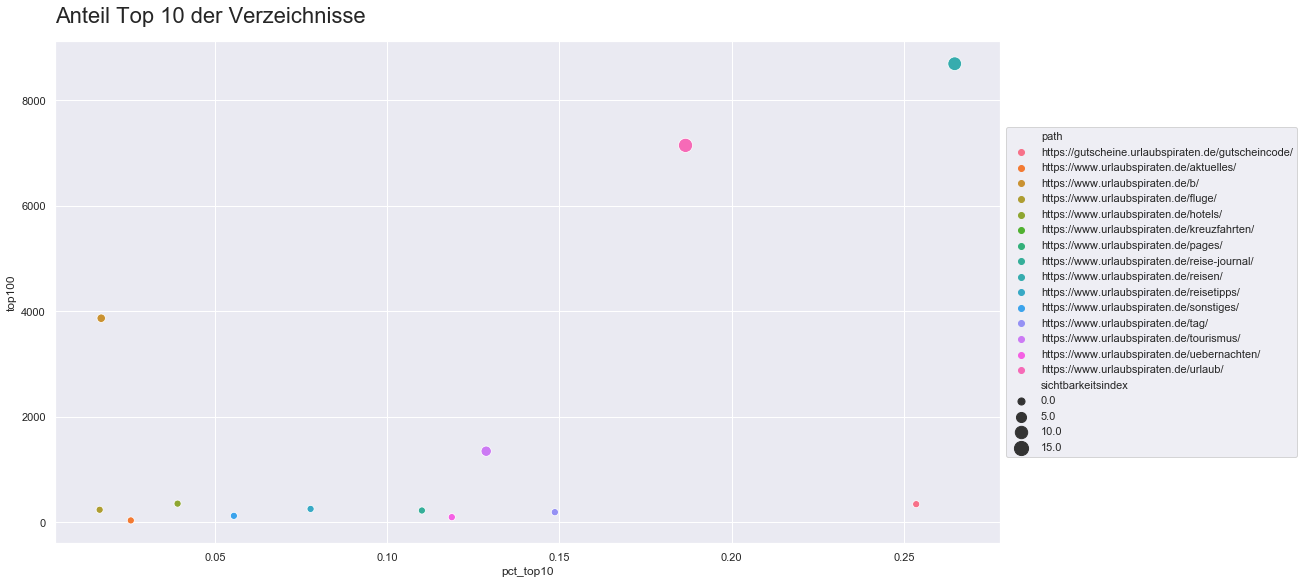

In [22]:
sns.set(rc={'figure.figsize':(18,8),
            'axes.titlesize':22,
            'axes.titlepad':18,
            'figure.constrained_layout.use':True})

ax = sns.scatterplot(x='pct_top10', y='top100', data=df,
                     hue='path', size='sichtbarkeitsindex',
                     sizes=(50,200))
legend = ax.legend(loc='center left', bbox_to_anchor=(1, .5))
title = ax.set_title('Anteil Top 10 der Verzeichnisse', ha='left', x=0)

Und so sieht der DataFrame als Tabelle aus:

In [23]:
df.sort_values('pct_top10', ascending=False)

,path,top100,top10,sichtbarkeitsindex,pct_top10
date,,,,,
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/reisen/,8694,2302.0,13.2644,0.264780
2019-03-25T00:00:00+01:00,https://gutscheine.urlaubspiraten.de/gutschein...,347,88.0,0.0211,0.253602
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/urlaub/,7147,1334.0,14.5425,0.186652
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/tag/,195,29.0,0.1364,0.148718
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/tourismus/,1351,174.0,5.4202,0.128793
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/uebernachten/,101,12.0,0.1202,0.118812
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/reise-journal/,227,25.0,0.0122,0.110132
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/reisetipps/,257,20.0,0.0449,0.077821
2019-03-25T00:00:00+01:00,https://www.urlaubspiraten.de/sonstiges/,126,7.0,0.0056,0.055556


## Interaktiver Plot mit Plotly
Da wir natürlich schlecht erkennen können, welche der Scatter-Punkte welche URL darstellt, sind interaktive Plots eine tolle Lösung. Eine sehr gute Library hierfür ist [Plotly](https://plot.ly/python/).

In [24]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = [go.Scatter(x=df['pct_top10'], 
                   y=df['top100'], 
                   mode='markers',
                   marker=dict(size=df['sichtbarkeitsindex'],
                               sizemode='area',
                               sizeref=2.*df['sichtbarkeitsindex'].max()/(100.**2),
                               sizemin=10,
                               opacity=.5),
                  text=df['path'].str.cat(df['sichtbarkeitsindex'].astype('str'), sep='<br>Si: '))]

layout = go.Layout(title='Sistrix HPCF', 
                   xaxis=dict(title='Anteil Top 10 Keywords (%)'), 
                   yaxis=dict(title='Top 100 Keywords',
                              range=[0,df['top100'].max()]),
                   height=800)

fig = go.Figure(data=data, layout=layout)

iplot(fig)